In [ ]:
import time

import glob
import csv 

import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt               # denoising
from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline # smooth lines
from mlxtend import evaluate, plotting # multiclass conf matrix

from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [ ]:
path = '/content/drive/MyDrive/tfm_ECG_INES_FernandezCampos/'

plt.rcParams["figure.figsize"] = (30,6)

# Dataset

Two approaches were implemented

1.   Access [physionet](https://physionet.org/content/mitdb/1.0.0/) data directly and try to convert the .dat files into csvs
2.   Downloaded already converted ECG data from [kaggle](https://www.kaggle.com/mondejar/mitbih-database?select=100annotations.txt) and uploaded it into colab


## Physionet

In [ ]:
import wfdb # WaveForm-Database: library for reading, writing, and processing WFDB signals and annotations

In [ ]:
from google.colab import auth

auth.authenticate_user()

In [ ]:
!pip install wfdb

!curl https://sdk.cloud.google.com | bash

In [ ]:
#sdk init
# project_id = 'tfmdataset'
!gcloud init

In [ ]:
# access the data using Google Cloud
!gsutil -m cp -r gs://mitdb-1.0.0.physionet.org .

Don't know why the file isn't found by *rdsamp()*, there shouldn't be a 'content' folder in path.

In [ ]:
dat_files = glob.glob('mitdb-1.0.0.physionet.org/*.dat') # list of all .dat files in current folder
df = pd.DataFrame(data=dat_files)

df.to_csv("files_list.csv", index=False, header=None) # write list to CSV file
files = pd.read_csv("files_list.csv", header=None)

for i in range(1,len(files)+1):
    fullfilename = str(files.iloc[[i]])
    shortfilename = fullfilename[-7:-4] # just the filename (the number)
    print(fullfilename[:-4])
    
    record = wfdb.rdsamp(shortfilename) # returns signal as a np array
    record = np.asarray(record[0])
    path = shortfilename+".csv"
    np.savetxt(path, record, delimiter=",") # write CSV for each record
    print("Files done: %s/%s"% (i, len(files)))

print("\nAll files done!")	

## Kaggle dataset


In [ ]:
import os
from google.colab import drive

### Load from drive

In [ ]:
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/tfm_ECG_INES_FernandezCampos/mit-bih-arrhythmia-database-1.0.0_csv_kaggle/mitbih_database')

Mounted at /content/drive


In [ ]:
files = glob.glob('*.csv') # list of all .csv files in current folder
annot = glob.glob('*.txt') # list of all annotations

nfiles = len(files)
nannot = len(annot)

print('nfiles:', nfiles)
print('nannot:', nannot)

nfiles: 48
nannot: 48


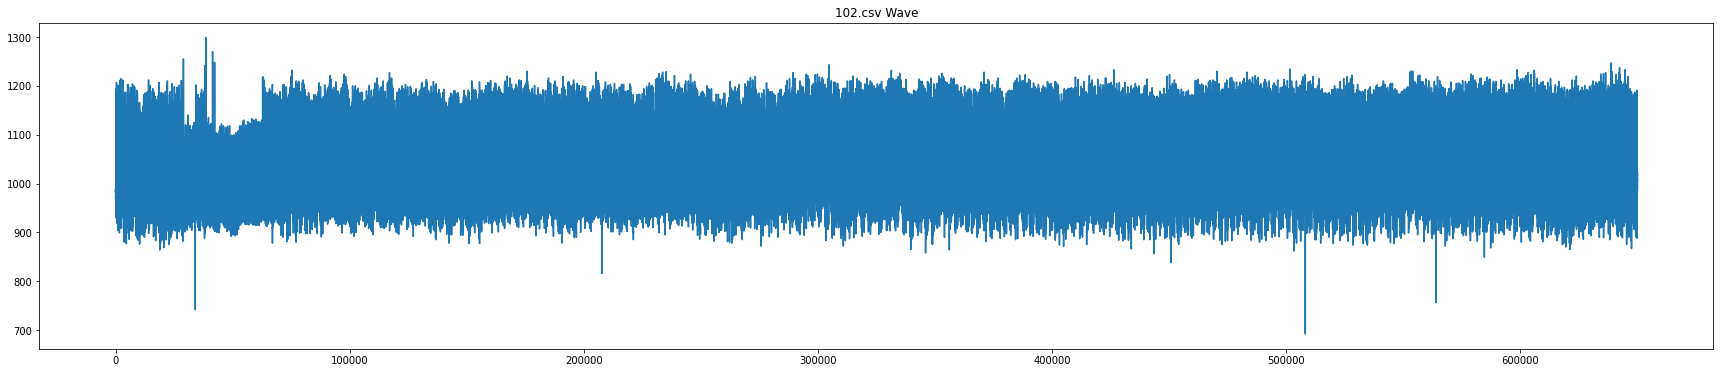

In [ ]:
# showing a record
j = 2
signals = []

with open(files[j], 'rt') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',') # read csv
    row_index = -1
    for row in csvreader:
        if(row_index >= 0):
            signals.insert(row_index, int(row[1]))
        row_index += 1

plt.title(files[j] + " Wave")
plt.plot(signals)
plt.show()

### Análisis por electrodo

Go through some signals and see what electrode seems to be clearer in order to choose what electrode to process later on.

In [ ]:
flag = True # we assume all records to have 2 electrodes signals to choose from
popular = list() # see which electrodes are used the most

for i in range(0,nfiles):
    f = pd.read_csv(files[i], index_col=0)
    cols = list(f.columns)
    for c in range(0, len(cols)): popular.append(cols[c])
    if len(cols) < 2: 
        flag = False
        print('File %d has %d electrodes'%(i, len(cols)))

if flag == True: print('All files have 2 electrode signals to choose from!')

All files have 2 electrode signals to choose from!


See what the most popular electrodes are

In [ ]:
popular = {x: popular.count(x) for x in popular}
popular = dict(sorted(popular.items(), key=lambda item: item[1], reverse=True))
popular

{"'MLII'": 46, "'V1'": 40, "'V2'": 4, "'V4'": 1, "'V5'": 5}

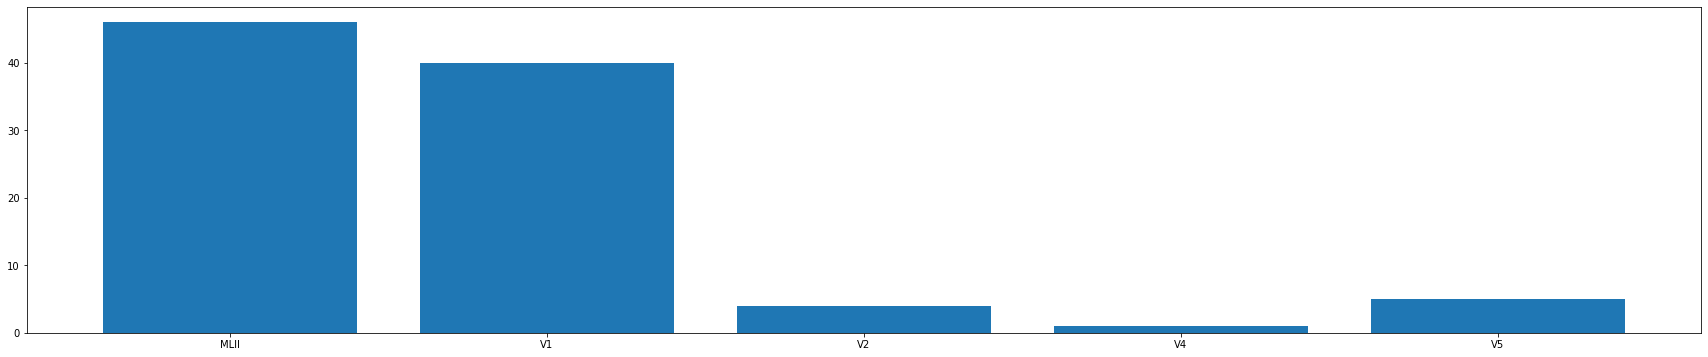

In [ ]:
D = {'MLII': 46, 'V1': 40, 'V2': 4, 'V4': 1, 'V5': 5}
plt.bar(*zip(*D.items()))
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (50,6)

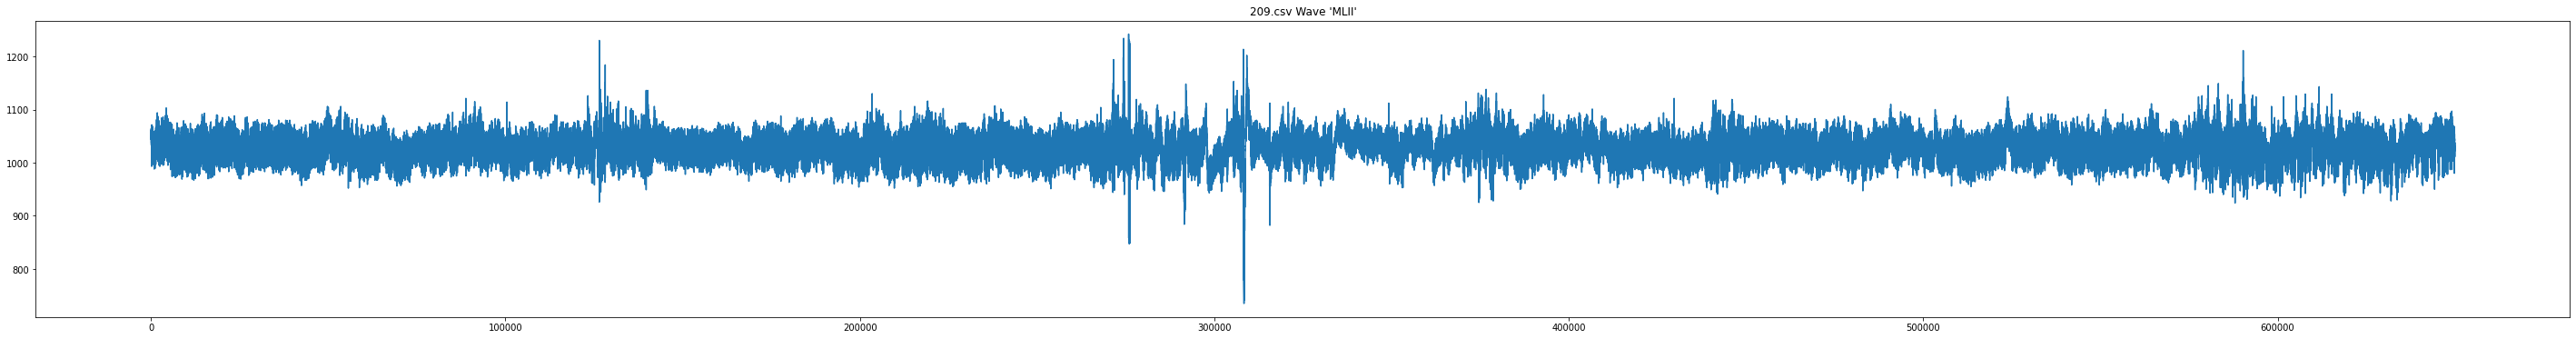

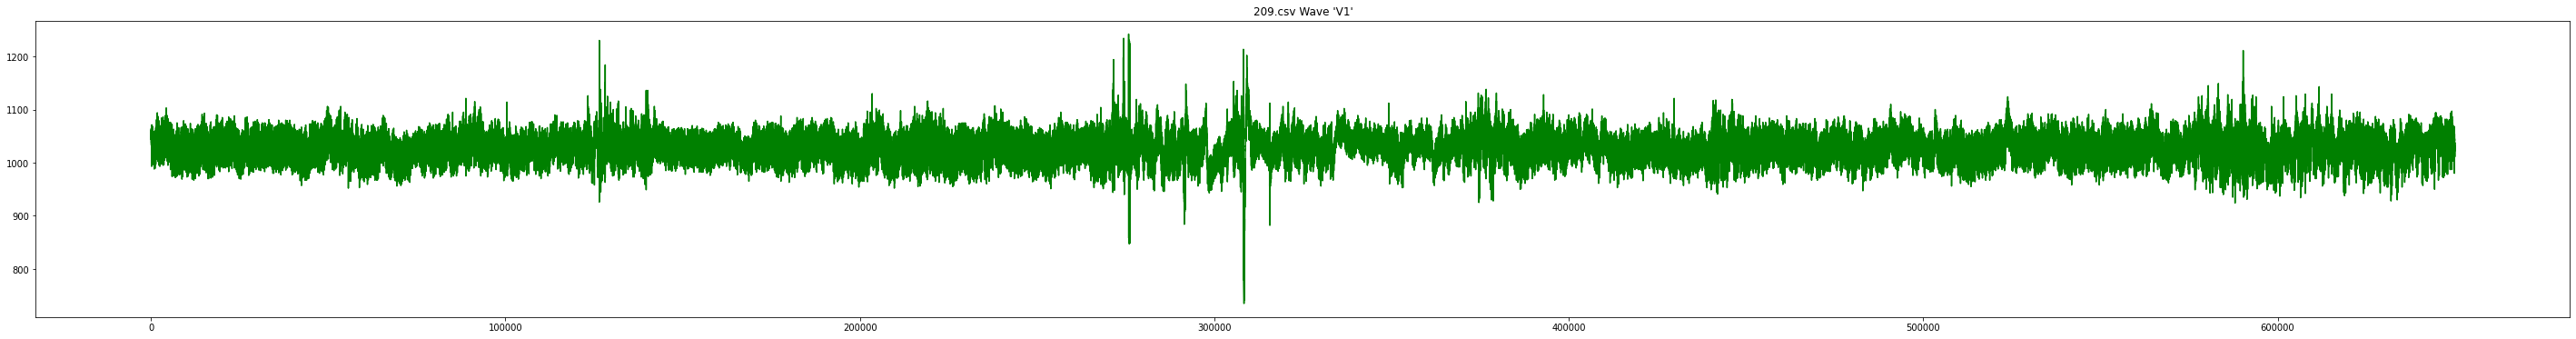

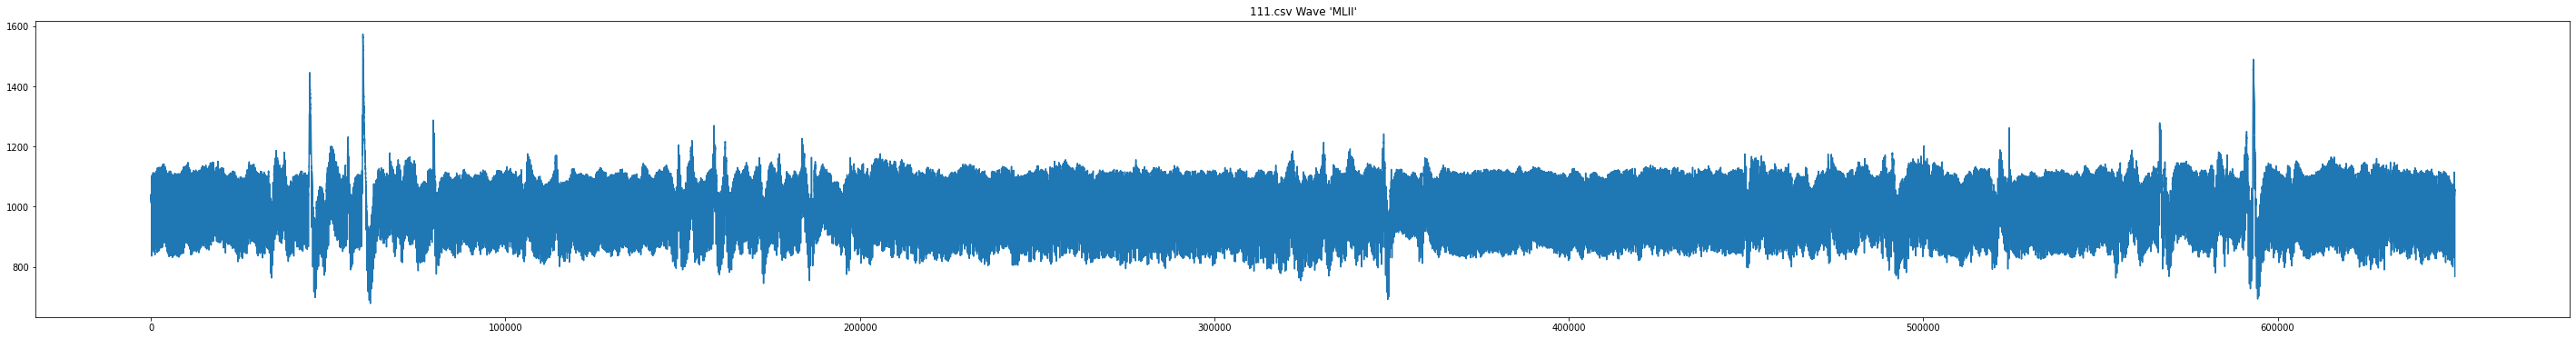

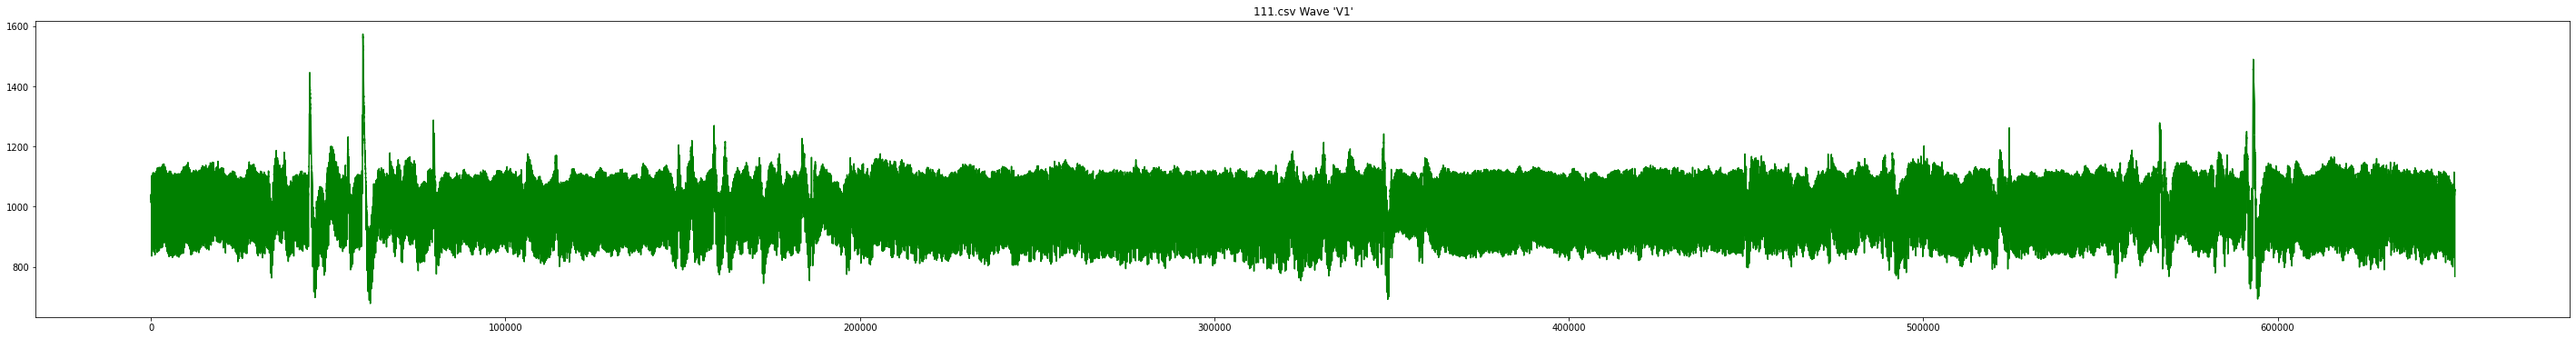

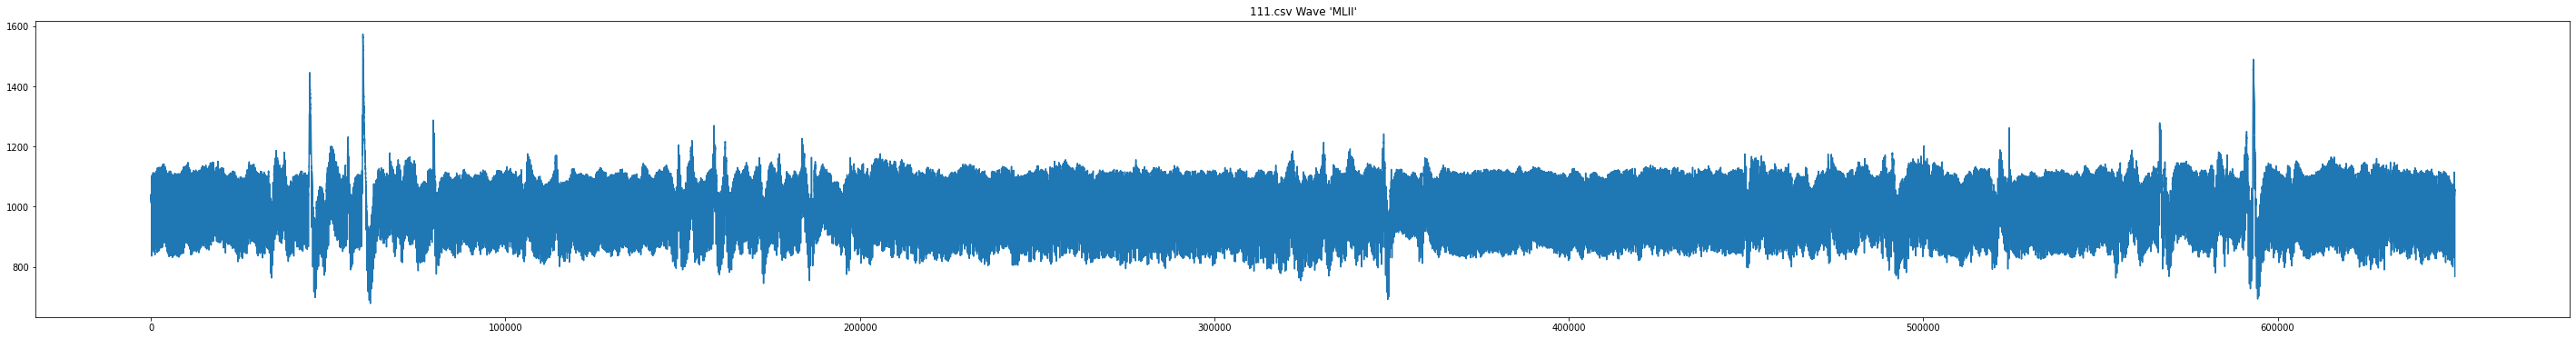

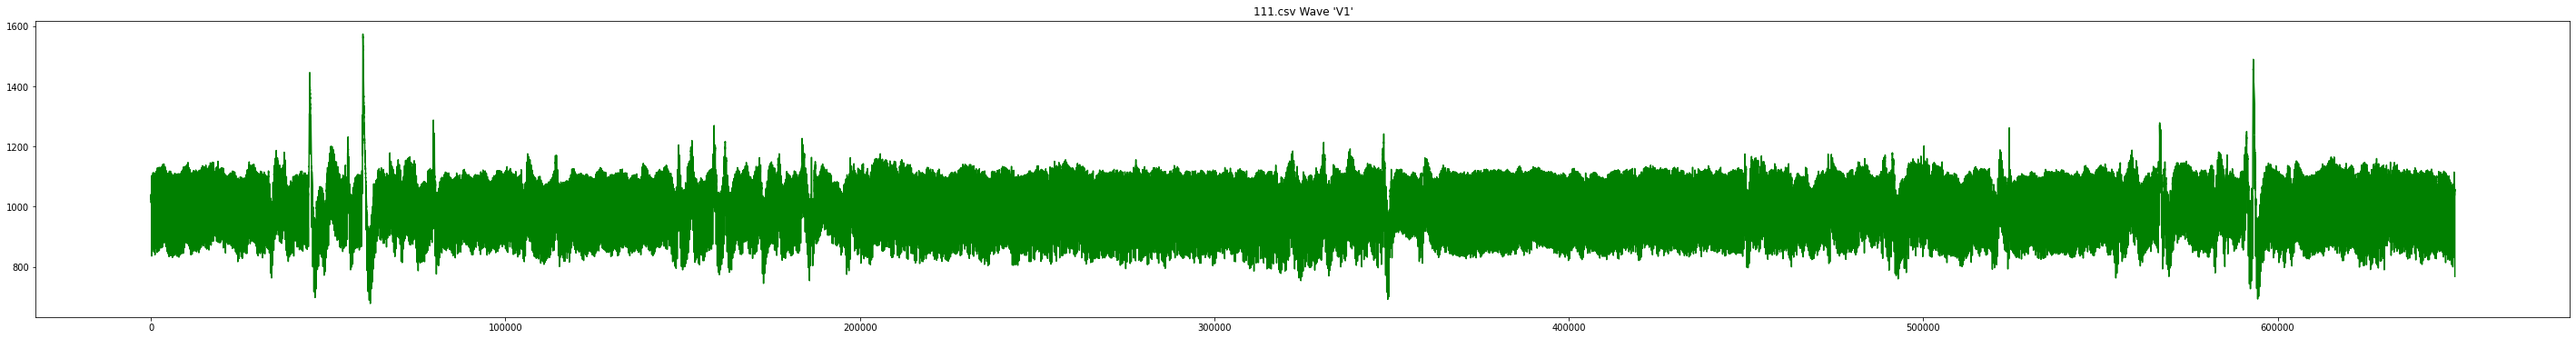

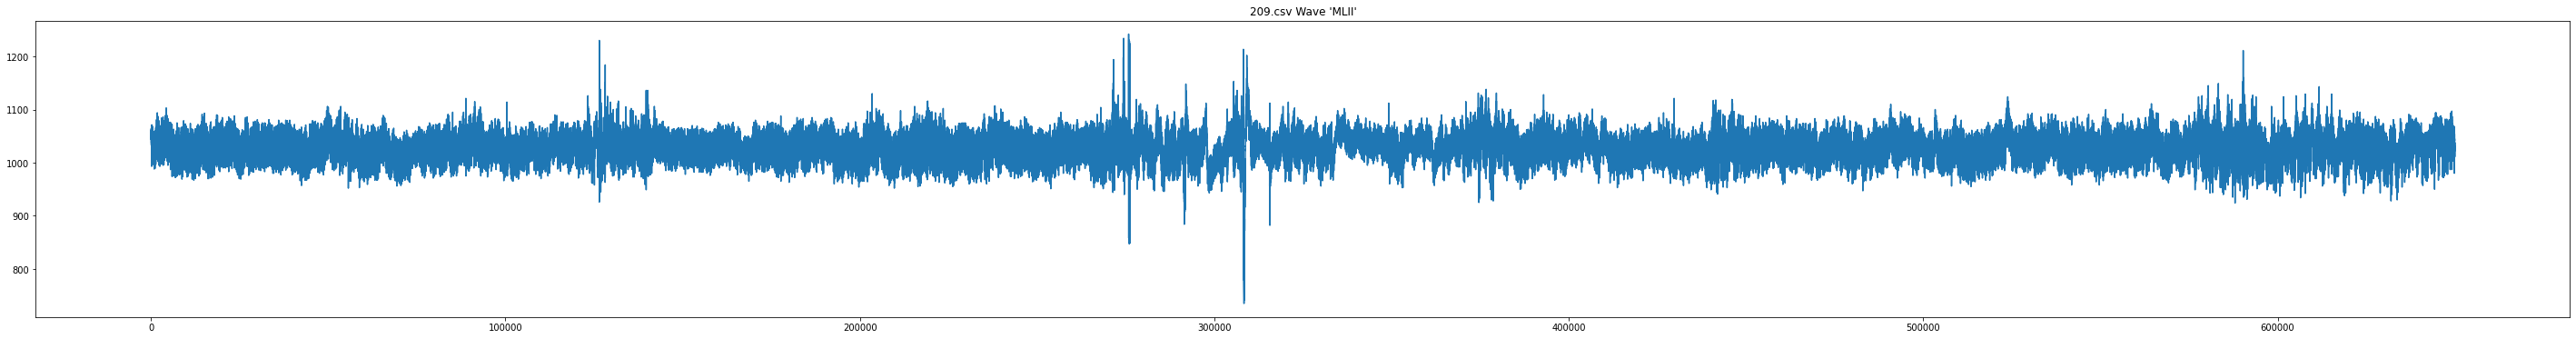

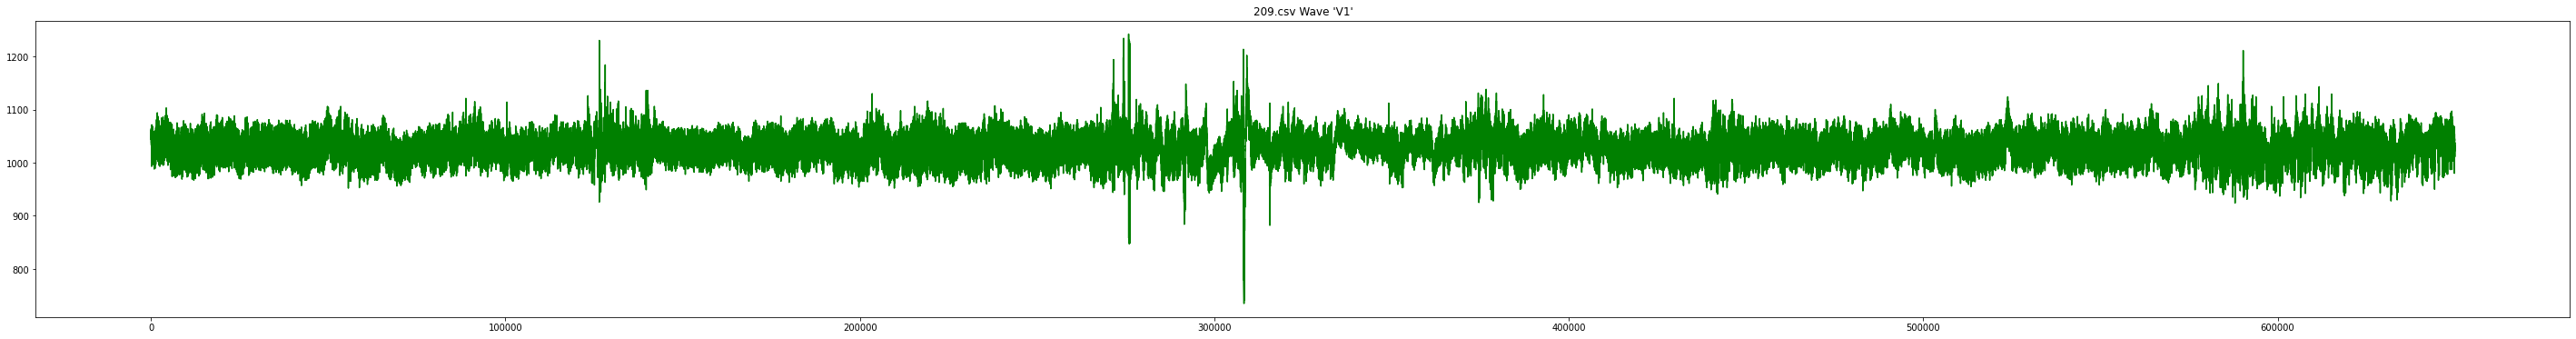

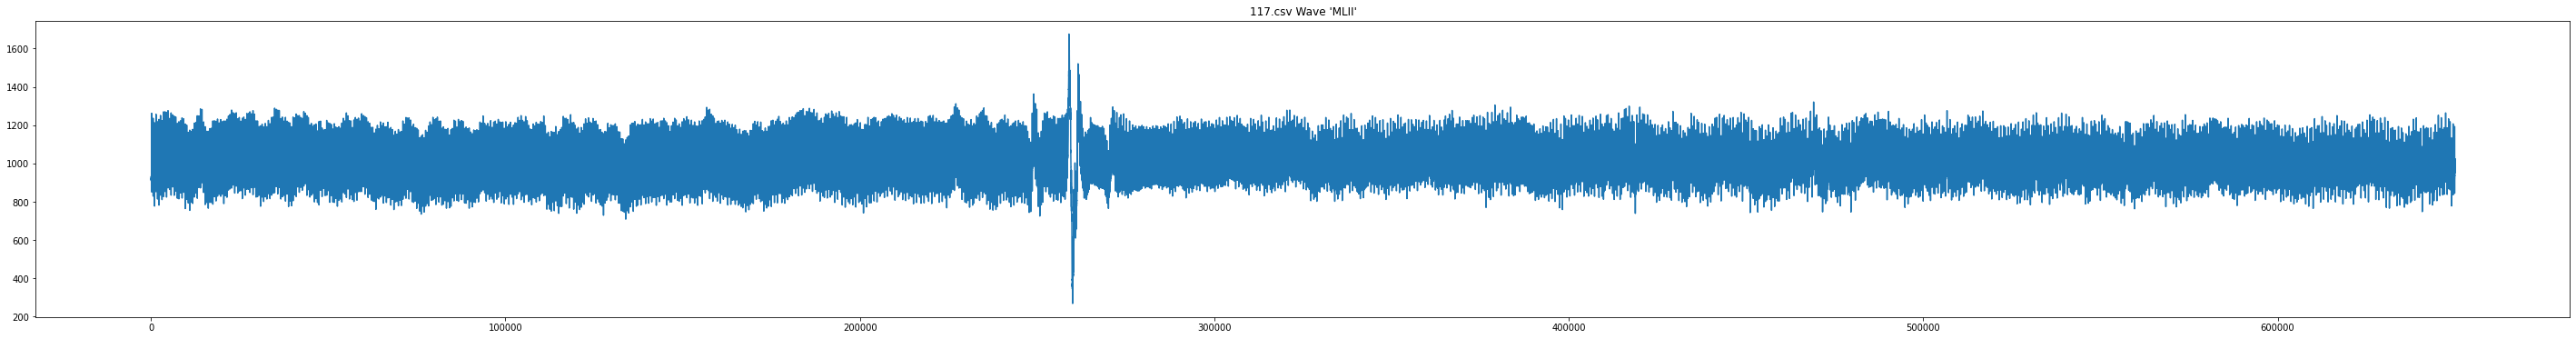

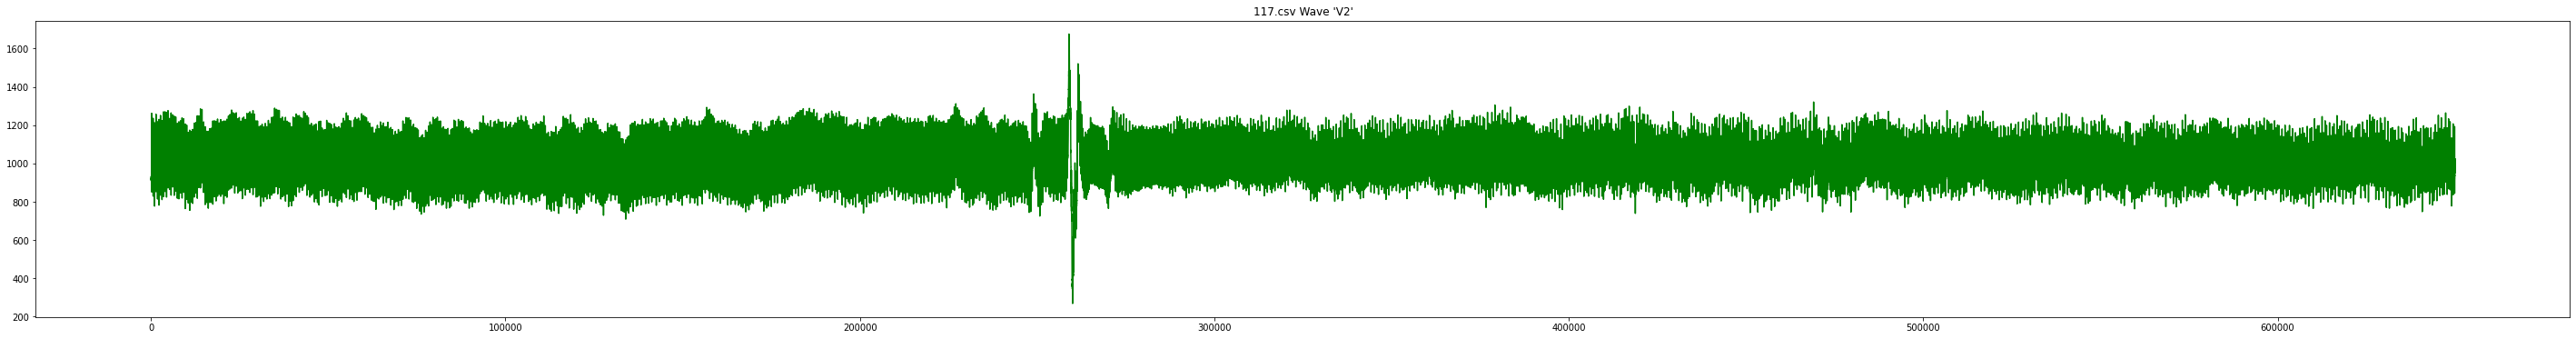

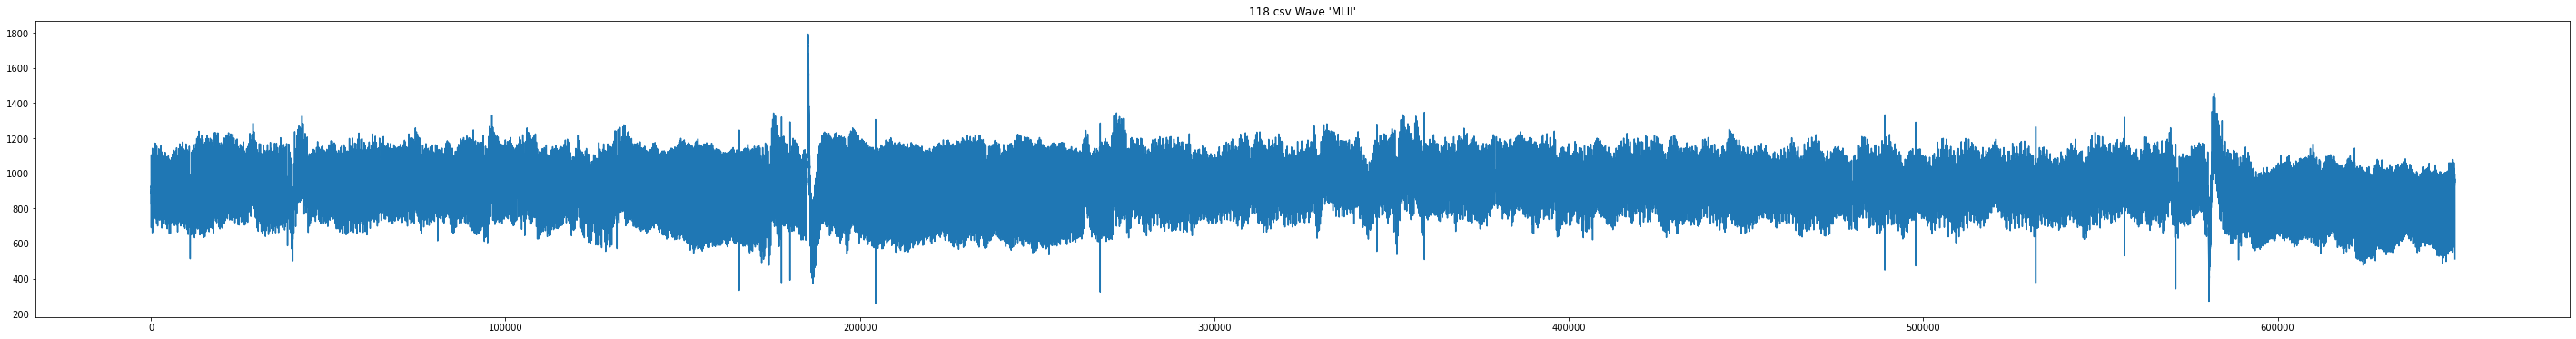

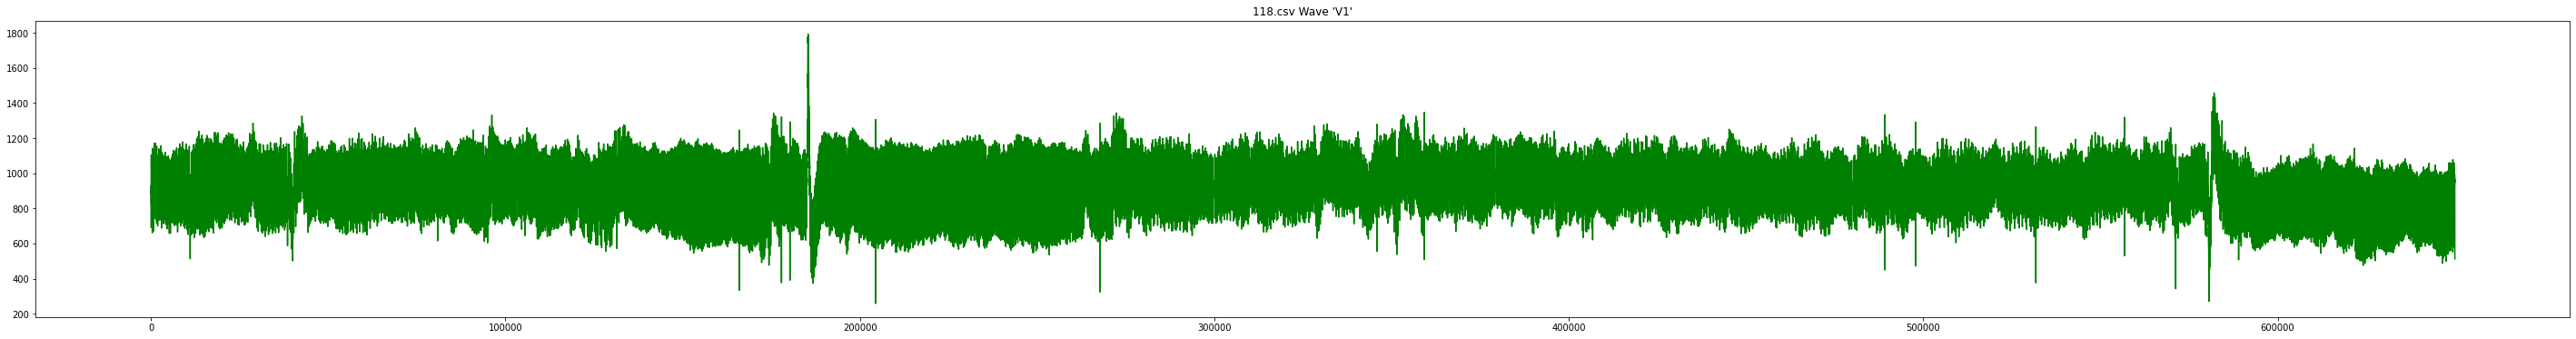

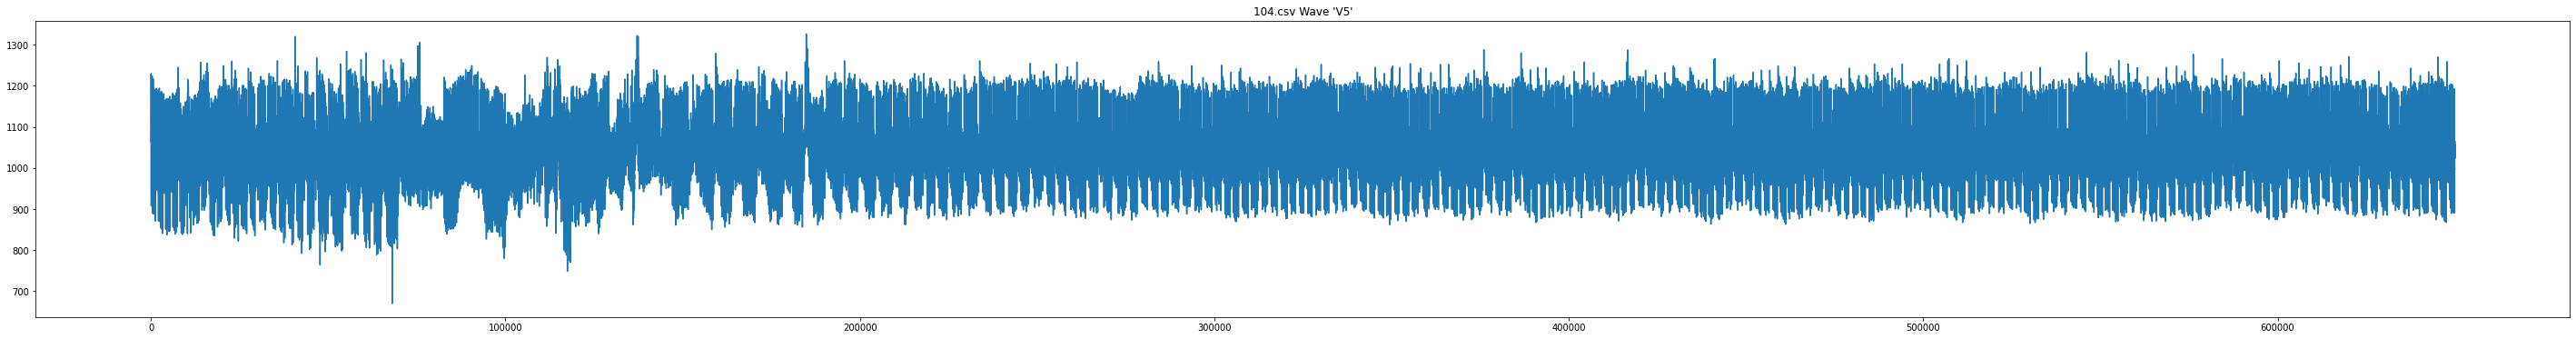

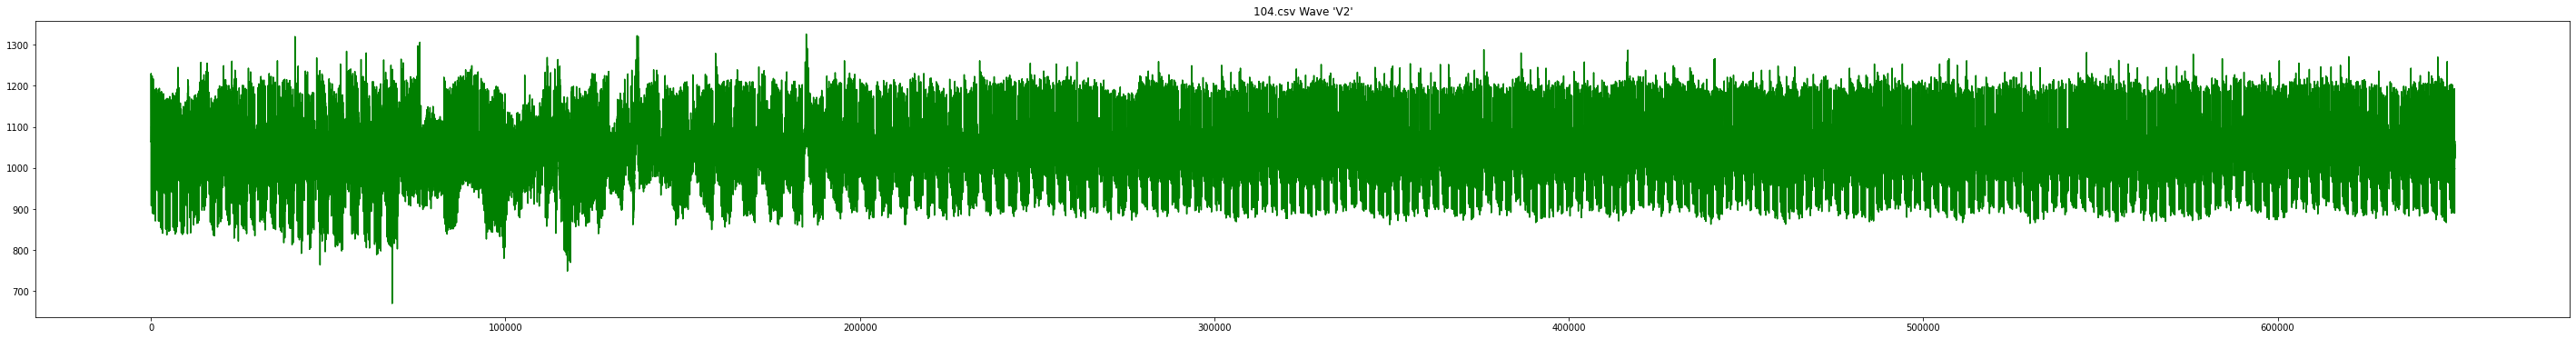

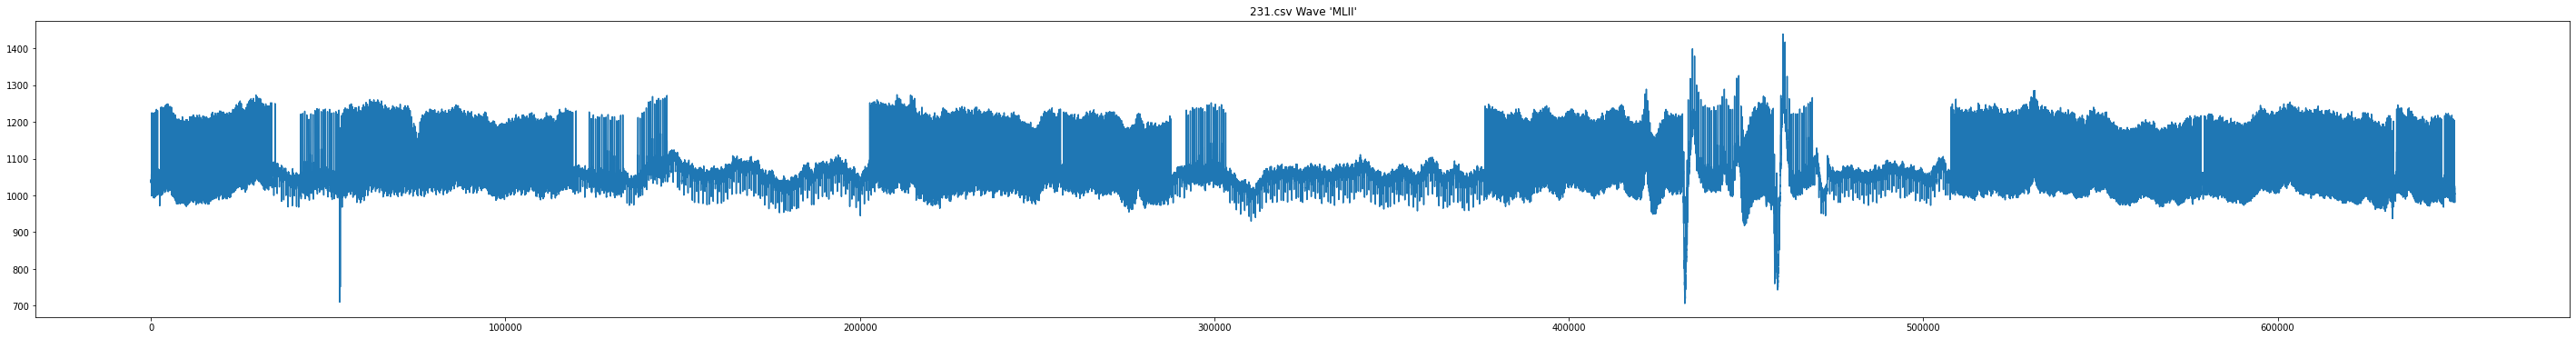

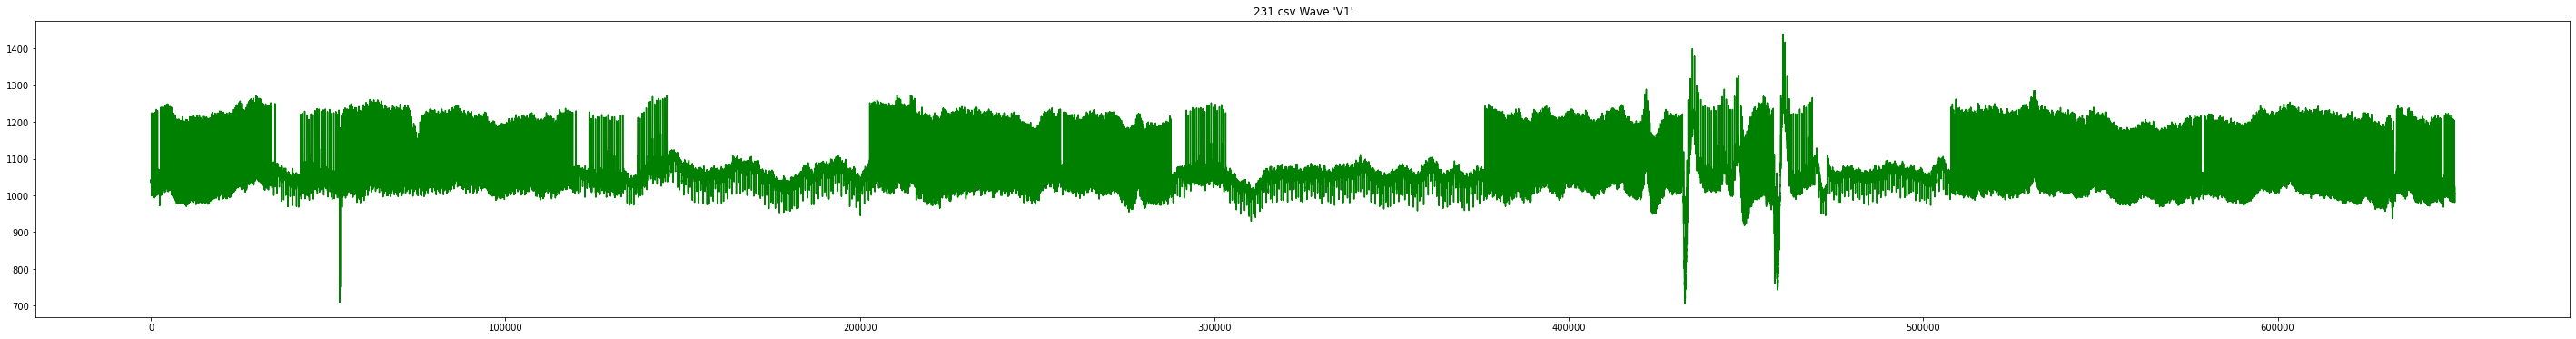

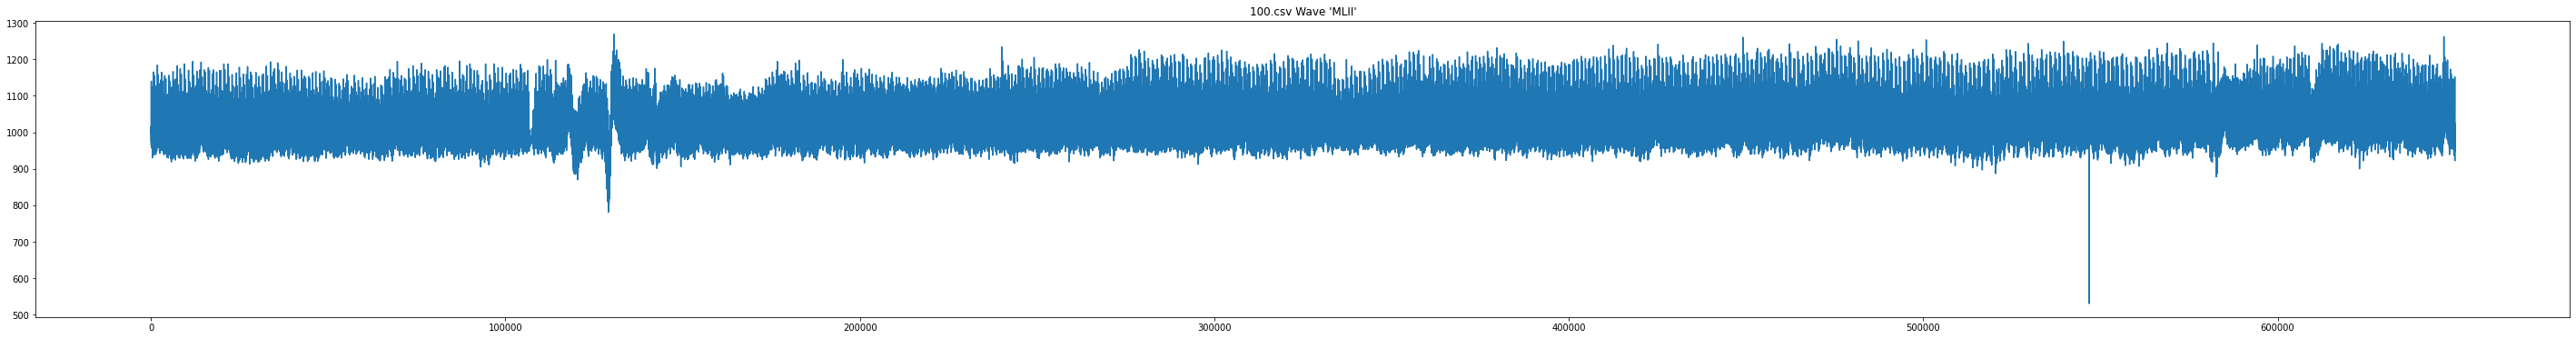

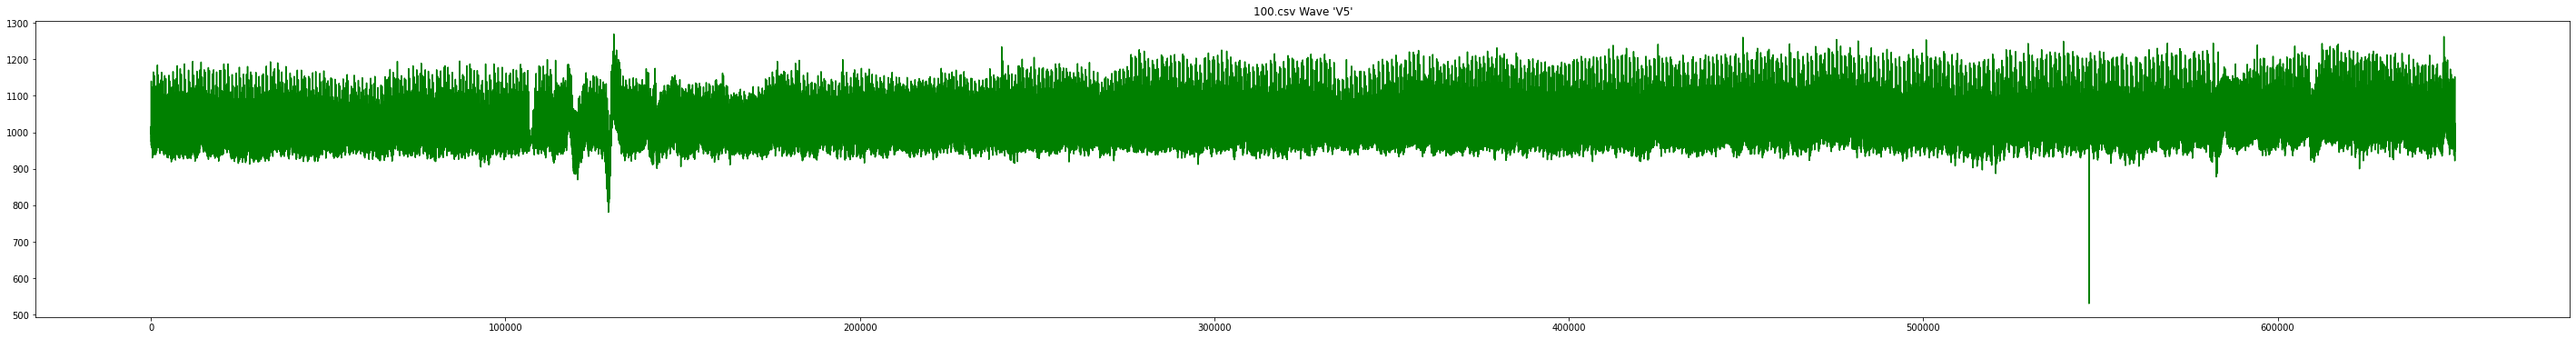

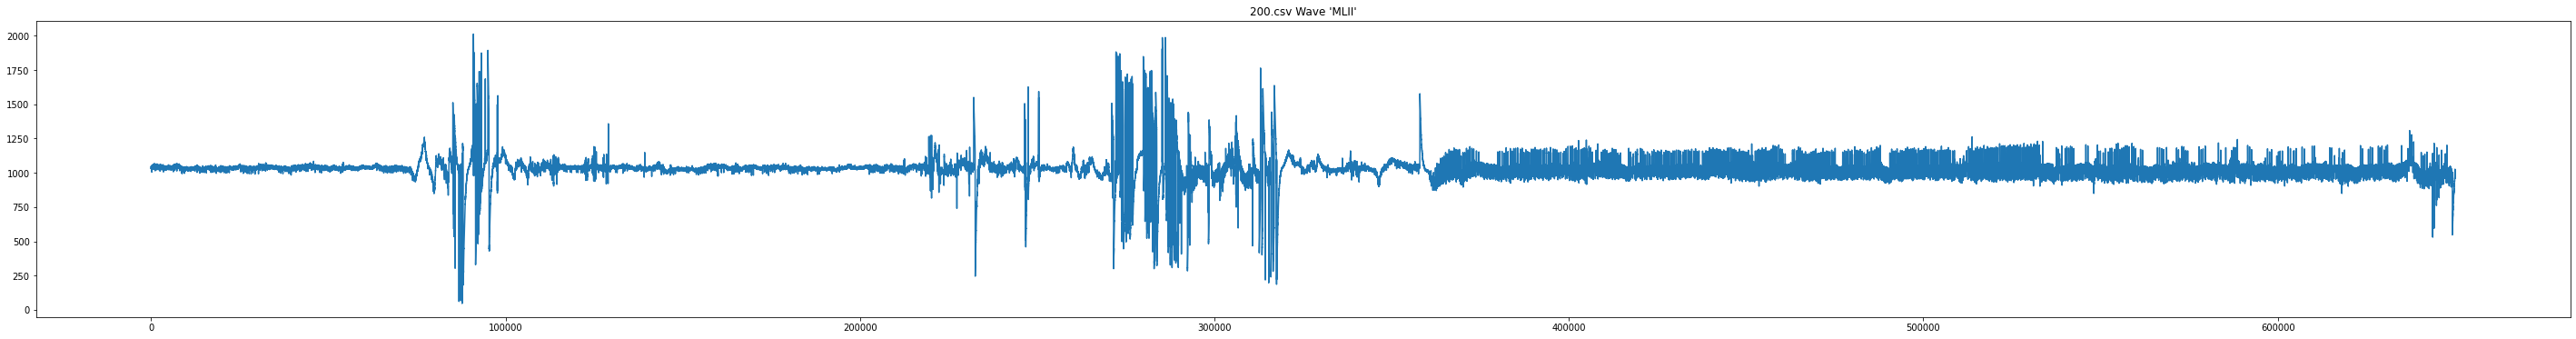

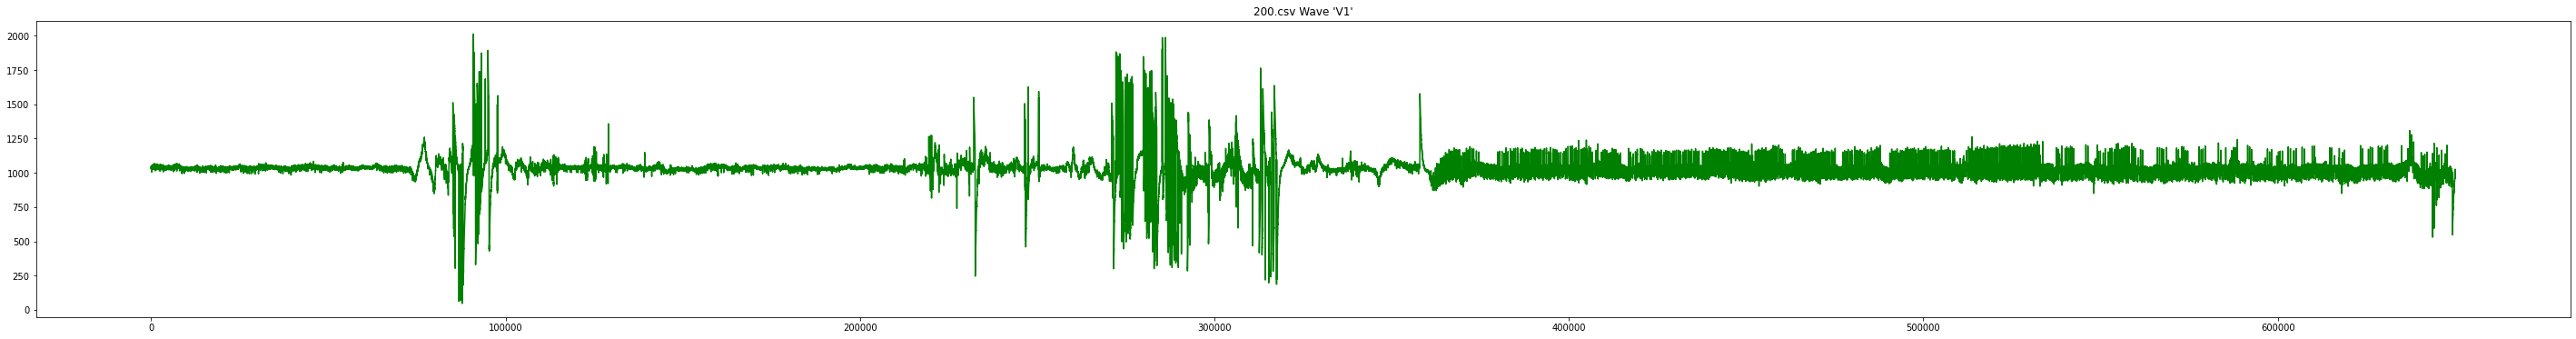

In [ ]:
rand_index = np.random.choice(nfiles, 10)

for j in rand_index:
    signal_1 = []
    signal_2 = []


    with open(files[j], 'rt') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',') # read csv
        row_index = -1
        for row in csvreader:
            if row_index < 0: elec_1, elec_2 = row[1:]
            if row_index >= 0:
                signal_1.insert(row_index, int(row[1]))
                signal_2.insert(row_index, int(row[2]))
            row_index += 1

    plt.title(files[j] + ' Wave ' + elec_1)
    plt.plot(signal_2)
    plt.show()

    plt.title(files[j] + ' Wave ' + elec_2)
    plt.plot(signal_2, color='green' )
    plt.show()

No discrepancies are detected. Both signals seem to be good and pretty much the same, we are just going to pick the first. (Seem to be ordered in popularity anyway)

### Processing the signal

https://physionet.org/physiobank/database/html/mitdbdir/intro.htm


The window size has been set knowing that for the ECMs we want several beats per window. 
By hand we have estimated that:

| Beats per window 	| Window size 	|
|:----------------:	|:-----------:	|
|         1        	|     140     	|
|         3        	|     340     	|
|         5        	|     720     	|
|         7        	|     1060     	|

In [ ]:
MAXPERCLASS = 10000  # we set a maximum number of all given types of arrhythmias to avoid overfitting on a specific type
WINDOW_SIZE = 340    # we want each window to have several beats

# classes = ['N', 'L', 'R', 'A', 'V', '/']
classes = ['N', 'L', 'R', 'A', 'V', '/',  'a', 'J', 'S', 'F', 'e', 'j', 'E', 'Q', 'x','f', '!', '[', ']']
nclasses = len(classes)
count_classes = np.zeros(nclasses)

In [ ]:
X = list()
y = list()

for i in range(0, nfiles):
# for i in range(0, 6):
    if i%6 == 0:
        print('{} files processed...'.format(i))

    # records
    signals = []

    with open(files[i], 'rt') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',') # read csv
        row_index = -1
        for row in csvreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # anotations: R position and Arrhythmia class
    with open(annot[i], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        ''' an annotations file looks like so:
        Time   Sample #  Type  Sub Chan  Num	Aux
        0:00.050   18     +    0    0    0	
        '''
        for d in range(1, len(data)):               # 0 is chart head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)                          # time
            pos = int(next(splitted))               # sample
            arr_type = next(splitted)               # type

            if arr_type in classes:
                arr_index = classes.index(arr_type)
                if count_classes[arr_index] > MAXPERCLASS: pass
                else:
                    '''
                    el beat debe ser simetrico:
                        comprobamos pos > WS porque sino se quedaría sin parte izq
                        comprobamos pos < (len(signals) - WINDOW_SIZE)) porque sino se quedaría sin parte dcha
                    '''
                    if (WINDOW_SIZE < pos and pos < (len(signals) - WINDOW_SIZE)):
                        beat = signals[pos-WINDOW_SIZE+1:pos+WINDOW_SIZE]
                        X.append(beat)
                        y.append(arr_index) # the label is the type of arrh
                    
                    count_classes[arr_index] += 1

0 files processed...
6 files processed...
12 files processed...
18 files processed...
24 files processed...
30 files processed...
36 files processed...
42 files processed...


In [ ]:
# data
print('X shape: ', np.shape(X))
print('y shape: ', np.shape(y))

X shape:  (35685, 679)
y shape:  (35685,)


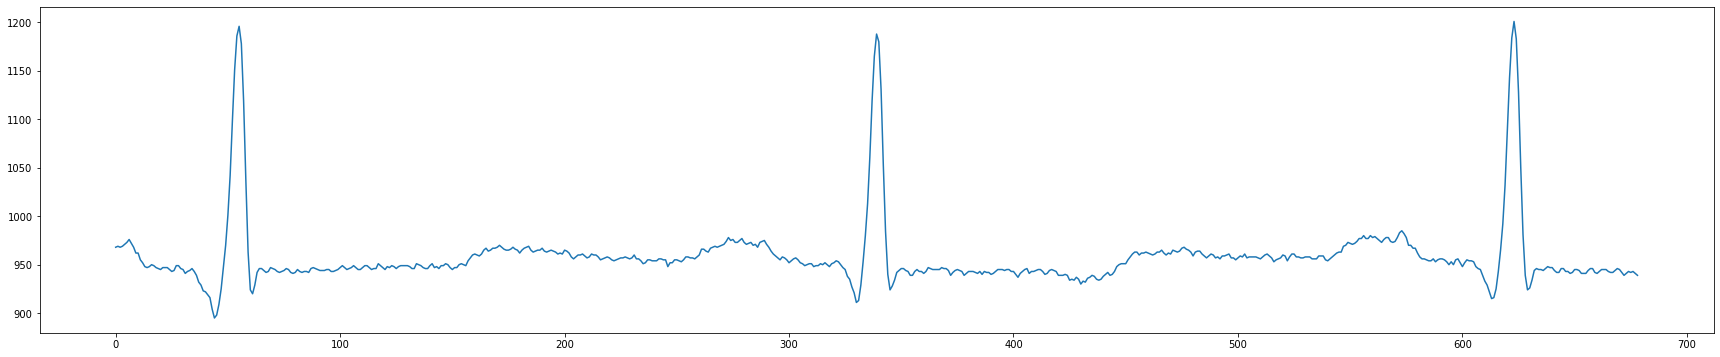

In [ ]:
# for the plot
i = 3

# beat plot
plt.plot(X[i])

### Denoising the signal
Filtro de paso bajo 40Hz

Low-pass filter, passes signals with a frequency lower than a certain cutoff frequency and attenuates signals with frequencies higher than the cutoff frequency

In [ ]:
fs = 360    # sample rate
T = 1/fs    # sample period
cutoff = 40 # cutoff freq of the filter Hz
nyq = 0.5 * fs

In [ ]:
def lowpass_filter(signal, cutoff, fs, order=2):
    normal_cutoff = cutoff / nyq
    
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

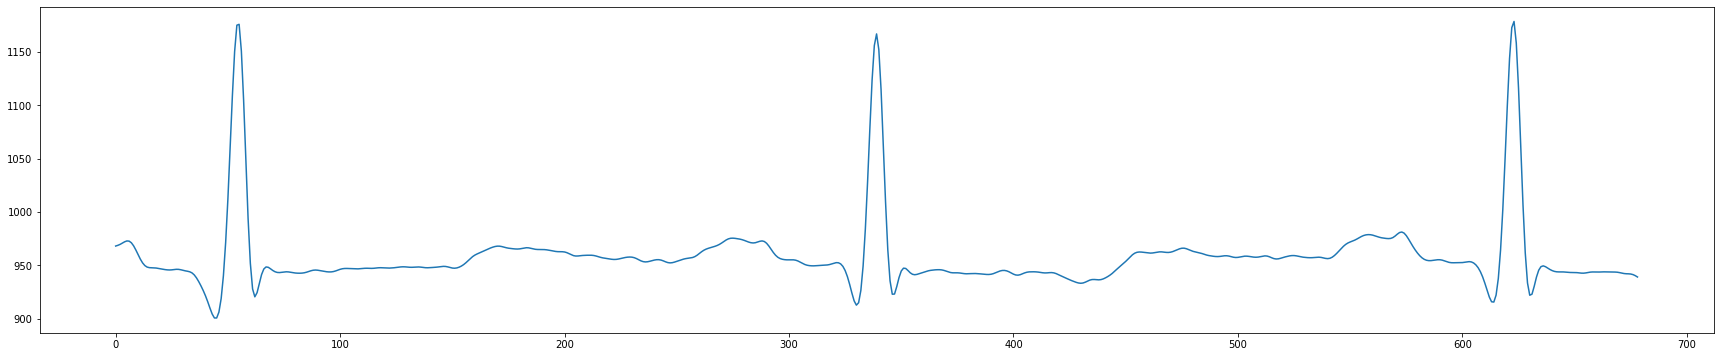

In [ ]:
# see how it affects 1 signal
lp = lowpass_filter(X[3], cutoff, fs)
plt.rcParams["figure.figsize"] = (30,6)
plt.plot(lp)

In [ ]:
# apply denoising to all
for i in range(0, len(X)):
    X[i] = lowpass_filter(X[i], cutoff, fs)

In [ ]:
X = np.asarray(X)
np.savetxt(path + 'allclasses_denoised_signals_3peak', X, delimiter=",")

y = np.asarray(y)
np.savetxt(path + 'allclasses_signals_classes_3peak', y, delimiter=",")

In [ ]:
X = np.loadtxt(path + 'allclasses_denoised_signals_3peak', delimiter=',')
y = np.loadtxt(path + 'allclasses_signals_classes_3peak', delimiter=',')

# X = np.loadtxt(path + 'denoised_signals_3peak', delimiter=',')
# y = np.loadtxt(path + 'signals_classes_3peak', delimiter=',')

print(X.shape)
print(y.shape)

(35685, 679)
(35685,)


#### Instances of every class

In [ ]:
Xy = np.zeros( (X.shape[0], X.shape[1]+1) )

for i in range(0,len(X)):
    Xy[i] = np.append(X[i],y[i])
print(np.shape(Xy))

(35685, 680)


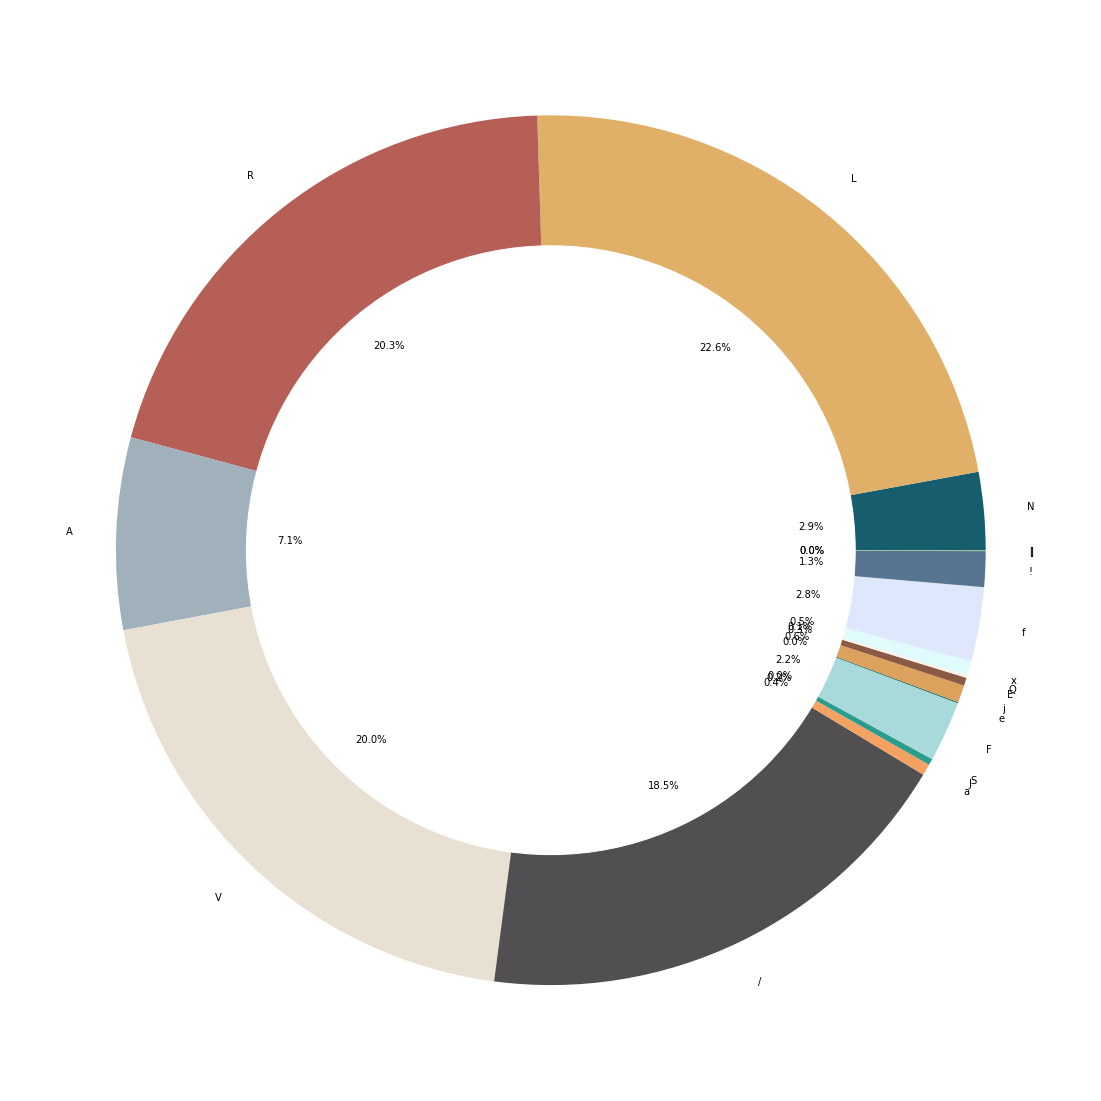

,arrhythmia,number
0.0,N,1031
1.0,L,8068
2.0,R,7251
3.0,A,2545
4.0,V,7126
5.0,/,6584
6.0,a,150
7.0,J,83
8.0,S,2
9.0,F,802


In [ ]:
# representation of instances of every class
df = pd.DataFrame(Xy)
per_class = df[df.shape[1]-1].value_counts()
per_class = per_class.sort_index()
auxdf = pd.DataFrame({'arrhythmia': classes, 'number': per_class})  


my_colors=['#165E6E','#E0B069','#B55F56','#A0B1BC','#E8E1D3','#514F51','#f4a261',
            '#2a9d8f', '#6b705c', '#a8dadc', '#2d6a4f', '#dda15e', '#8a5a44',
            '#fff1e6', '#e0fbfc', '#dfe7fd', '#577590', '#43aa8b', '#90be6d']

plt.figure(figsize=(20,20))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=classes, colors=my_colors, autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

display(auxdf)

# Create ECM


In [ ]:
X = np.loadtxt(path + 'allclasses_denoised_signals_3peak', delimiter=',')
y = np.loadtxt(path + 'allclasses_signals_classes_3peak', delimiter=',')

# X = np.loadtxt(path + 'denoised_signals_3peak', delimiter=',')
# y = np.loadtxt(path + 'signals_classes_3peak', delimiter=',')

print(X.shape)
print(y.shape)

(35685, 679)
(35685,)


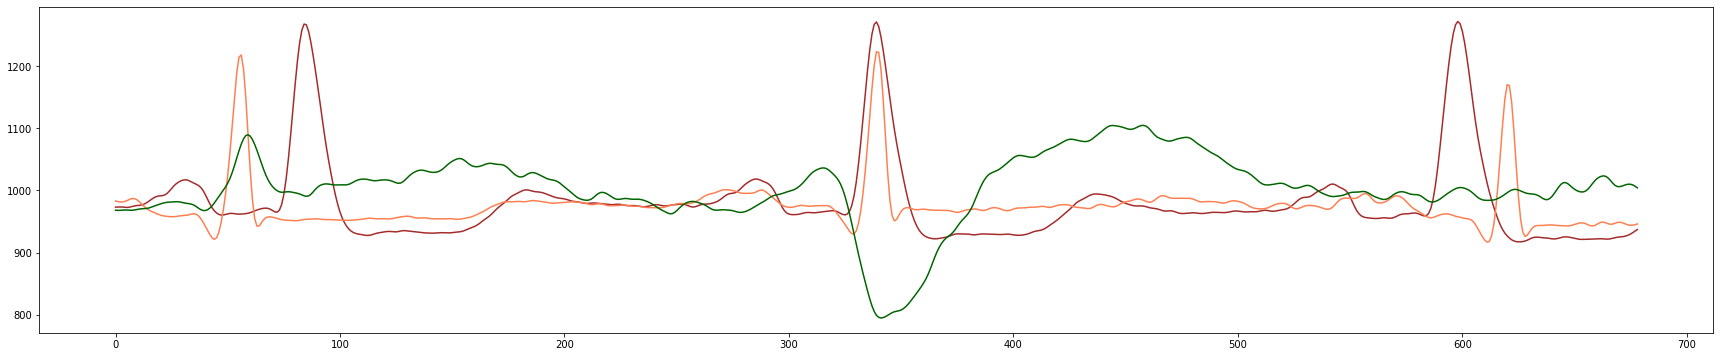

In [ ]:
npeaks = 3
indeces = np.random.choice(X.shape[0], npeaks)

colors = ['brown', 'coral','saddlebrown', 'orange', 'goldenrod', 'darkkhaki',
          'gold', 'lawngreen', 'darkgreen', 'mediumaquamarine', 'lightseagreen',
          'darkslategray', 'deepskyblue', 'dodgerblue', 'mediumslateblue',
          'darkorchid', 'fuchsia']
colors.sort() # so that all signals are not in similar shades

for i, index in enumerate(indeces):
    plt.plot(X[index], color=colors[i])

## Heatmaps

We procede to create heatmaps where each row of the heatmap represents 2 of the peaks of a window.

So for a 3 window peak:
1.   1st row will show peak_1 and peak_2
2.   2nd row will show peak_2 and peak_3

For a 5 window peak:
1.   1st row will show peak_1 and peak_2
2.   2nd row will show peak_2 and peak_3
3.   3rd row will show peak_3 and peak_4
4.   2nd row will show peak_4 and peak_5

And so forth.

**For *npeak* peaks, the matrix of signals will have *npeaks-2* rows.**

#### Splitting one signal to see what happens

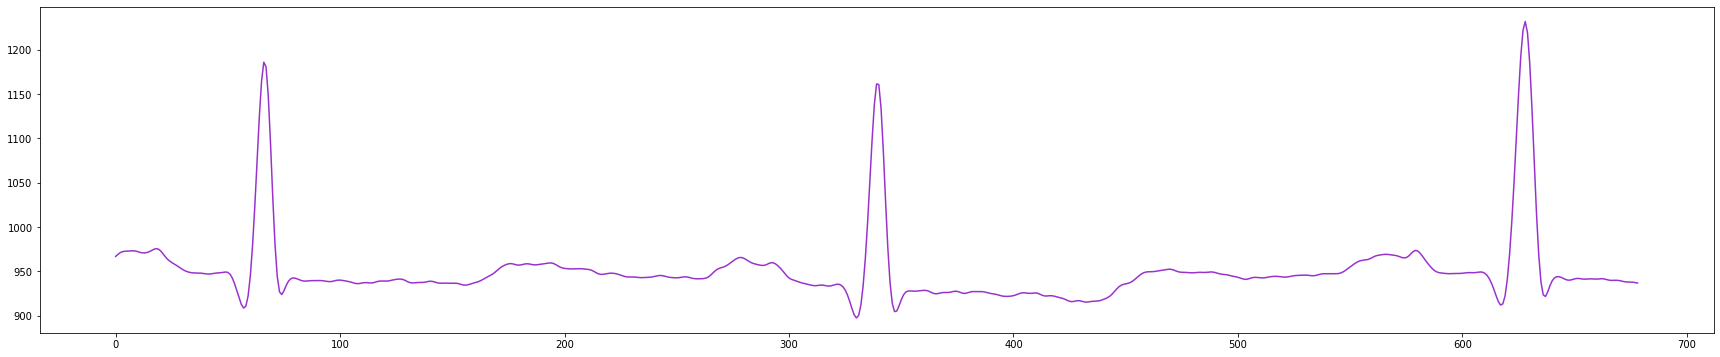

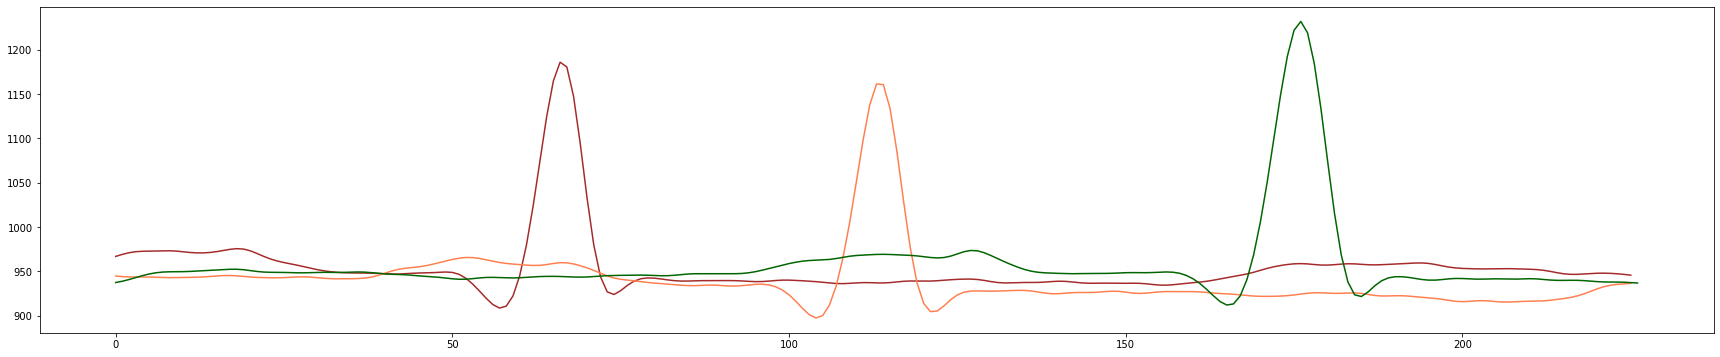

In [ ]:
plt.rcParams["figure.figsize"] = (30,6)

npeaks = 1
indeces = np.random.choice(X.shape[0], npeaks)

colors = ['brown', 'coral','saddlebrown', 'orange', 'goldenrod', 'darkkhaki',
          'gold', 'lawngreen', 'darkgreen', 'mediumaquamarine', 'lightseagreen',
          'darkslategray', 'deepskyblue', 'dodgerblue', 'mediumslateblue',
          'darkorchid', 'fuchsia']
colors.sort() # so that all signals are not in similar shades

plt.plot(X[indeces[0]], color=colors[4])
plt.show()

siglen = X.shape[1]
peaks = 3
for i in range(peaks):
    lower = int(i*(siglen/peaks))
    upper = int((i+1)*(siglen/peaks))
    plt.plot(X[indeces[0]][lower:upper], color=colors[i])

In [ ]:
a = np.random.rand(1, 2)
b = a * 2
c = a * 3
split_signals = [a,b,c]

matrix = np.zeros( (npeaks-1, split_signals[0].shape[1]*2) )
for j in range(npeaks-1):
    matrix[j] = np.ravel(np.concatenate( (split_signals[j], split_signals[j+1]) , axis=1))

### Creating matrices

In [ ]:
npeaks = 3
indeces = []

# define the split indeces
for i in range(1,npeaks):
    if i == 1 : indeces.append( int(X.shape[1]/npeaks) )
    else: indeces.append( int(X.shape[1]/npeaks)*i )

In [ ]:
maxshape = int(np.ceil(X.shape[1]/npeaks))                        # for padding
matrix_shape_cols = int(np.floor(X.shape[1]/npeaks)) + maxshape   # each matrix will have this num of cols
matrices = np.zeros( (X.shape[0], npeaks-1, matrix_shape_cols) )  # store all matrices created, 

#for i in range(4):
for i in range(X.shape[0]):
    split_signals = np.split(X[i], indices_or_sections=indeces)   # this is a list
    
    matrix = np.zeros( (npeaks-1, matrix_shape_cols) )  # matrix will store the concatenated pieces of signal
    for j in range(npeaks-1):
        aux = np.ravel(np.concatenate( (split_signals[j], split_signals[j+1])))              # signal concat 
        if aux.shape[0] < matrix_shape_cols: aux = np.append(aux, aux[-1])                   # add padding at end 

        matrix[j] = aux # store signal in matrix
    
    matrices[i, :, :] = matrix
# matrices[:,:,0].shape this is the matrix of one row of X
matrices.shape

(35685, 2, 453)

In [ ]:
np.save(path + 'allclasses_ecm_matrices_3peak', matrices)
# np.save(path + 'ecm_matrices_3peak', matrices)

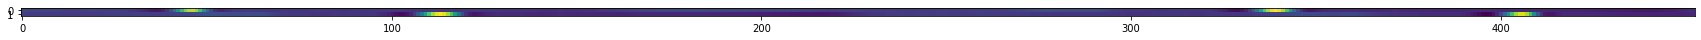

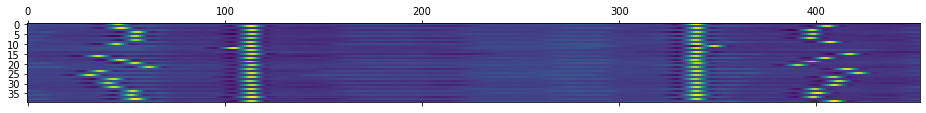

In [ ]:
plt.rcParams["figure.figsize"] = (30,20)
plt.imshow(matrices[0,:,:])

necms = 20
several = matrices[:necms, :, :].reshape((2*necms,453))
plt.matshow(several)

# Train, test split

In [ ]:
# matrices = np.load(path + 'ecm_matrices_3peak.npy')
matrices = np.load(path + 'allclasses_ecm_matrices_3peak.npy')
matrices.shape

(35685, 2, 453)

In [ ]:
# y = np.loadtxt(path + 'signals_classes_3peak', delimiter=',')
y = np.loadtxt(path + 'allclasses_signals_classes_3peak', delimiter=',')

In [ ]:
# divide dataset 
test_ratio = 0.3
valid_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(matrices, y, test_size=test_ratio)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=valid_ratio)

y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
y_test_numerical = y_test
y_test = to_categorical(y_test)

print("x_train : ", x_train.shape)
# print("x_val : ", x_val.shape)
print("x_test  : ", x_test.shape)
print()
print("y_train : ", y_train.shape)
# print("y_val : ", y_val.shape)
print("y_test  : ", y_test.shape)

x_train :  (24979, 2, 453)
x_test  :  (10706, 2, 453)

y_train :  (24979, 19)
y_test  :  (10706, 18)


# Networks

In [ ]:
import torch
from torch import nn
from torch import optim

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Softmax, BatchNormalization, Activation
from keras.layers import Conv1D, Conv2D, Bidirectional, LSTM, MaxPool2D, MaxPooling1D

from keras.callbacks import ModelCheckpoint, Callback
from keras.models import load_model

from keras.utils.vis_utils import plot_model

In [ ]:
# classes = ['N', 'L', 'R', 'A', 'V', '/']
classes = ['N', 'L', 'R', 'A', 'V', '/',  'a', 'J', 'S', 'F', 'e', 'j', 'E', 'Q', 'x','f', '!', '[', ']']
nclasses = len(classes)

print(nclasses)

19


## Common Callbacks


In [ ]:
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]

    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [ ]:
class MonitorCallback(Callback):
    best_train_loss = 10000.02
    best_val_loss = 10000.02

    def on_epoch_end(self, epoch, logs={}): 
        current_val = logs.get('val_loss')
        current_train = logs.get('loss')

        if (current_train < self.best_train_loss and current_val < self.best_val_loss):
            self.best_train_loss = current_train
            self.best_val_loss = current_val
            model.save(filepath)
            print('Saved model with train loss %.4f and val loss %.4f at epoch %d' % (current_train, current_val, epoch+1))

# best_val_loss = sys.float_info.max 
# def saveModel(epoch,logs):
#     val_acc = logs['val_acc']
#     val_loss = logs['val_loss']

#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         model.save(...)
#     elif val_acc == best_val_acc:
#         if val_loss < best_val_loss:
#             best_val_loss=val_loss
#             model.save(...)
# callbacks = [LambdaCallback(on_epoch_end=saveModel)]

## CNN


### ((conv_relu)2_pool_drop)2_dense_drop_dense


In [ ]:
# CONV => RELU => POOL
model = Sequential(name='conv_relu_pool')
inputShape = (x_train.shape[1], x_train.shape[2])

model.add(Conv1D(filters=64, kernel_size=1, strides=1, input_shape=inputShape, name='conv_1'))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv1D(filters=64, kernel_size=1, strides=1, name='conv_2'))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Conv1D(filters=128, kernel_size=1, strides=1, name='conv_3'))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv1D(filters=128, kernel_size=1, strides=1, name='conv_4'))
model.add(Activation("relu"))
model.add(BatchNormalization())

# model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(nclasses, activation='softmax', name='dense_2'))

# model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics= ['accuracy'])

In [ ]:
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# define the checkpoint
EPOCHS = 200

filepath = path + "allclasses_conv_relu_pool_bestscores_{}.hdf5".format(EPOCHS)
checkpoint_train = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

# filepath_val = path + "allclasses_val_conv_relu_pool_{}.hdf5".format(EPOCHS)
# checkpoint_val = ModelCheckpoint(filepath_val, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint_train]

In [ ]:
# H = model.fit(x_train, y_train, validation_split=0.2, epochs=EPOCHS, verbose=1, callbacks=callbacks_list)

tc = TimingCallback()
callbacks = [MonitorCallback(), tc]

H = model.fit(x_train, y_train, validation_split=0.2, epochs=200, verbose=1, callbacks=callbacks)

print('TOTAL TIME: ', sum(tc.logs))

# Save model
model.save(path + "allclasses_conv_relu_pool_endoftraining_{}.h5".format(EPOCHS))

Epoch 1/200
625/625 [==============================] - 10s 11ms/step - loss: 0.3887 - accuracy: 0.5444 - val_loss: 0.4621 - val_accuracy: 0.2424
Saved model with train loss 0.1799 and val loss 0.4621 at epoch 1
Epoch 2/200
625/625 [==============================] - 6s 10ms/step - loss: 0.0507 - accuracy: 0.8544 - val_loss: 0.2544 - val_accuracy: 0.4498
Saved model with train loss 0.0463 and val loss 0.2544 at epoch 2
Epoch 3/200
625/625 [==============================] - 6s 10ms/step - loss: 0.0367 - accuracy: 0.8901 - val_loss: 0.1479 - val_accuracy: 0.5685
Saved model with train loss 0.0356 and val loss 0.1479 at epoch 3
Epoch 4/200
625/625 [==============================] - 6s 10ms/step - loss: 0.0320 - accuracy: 0.9024 - val_loss: 0.5216 - val_accuracy: 0.1869
Epoch 5/200
625/625 [==============================] - 6s 10ms/step - loss: 0.0271 - accuracy: 0.9226 - val_loss: 0.2550 - val_accuracy: 0.3893
Epoch 6/200
625/625 [==============================] - 6s 10ms/step - loss: 0.024

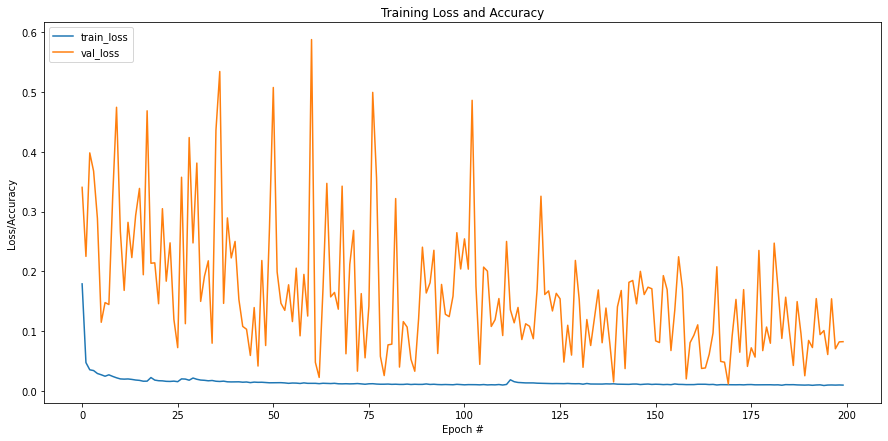

In [ ]:
# plot the training loss and accuracy
plt.figure(figsize=(15,7))

plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")

# plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

pltname = path + 'allclasses_conv_relu_pool{}.png'.format(EPOCHS)
plt.savefig(pltname)

### Evaluation

In [ ]:
EPOCHS = 200
filepath = path + "allclasses_conv_relu_pool_bestscores_{}.hdf5".format(EPOCHS)

# load the model
model = load_model(filepath)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

In [ ]:
# from sklearn.metrics import multilabel_confusion_matrix

# y_pred = model.predict_classes(x_test)
# ided_classes = list(np.unique(y_pred)) # classes that have been found
# y_pred = to_categorical(y_pred)

# missing_classes = []
# if y_pred.shape[1] != y_test.shape[1]:
#     aux = np.zeros( (y_pred.shape[0], 1) )
    
#     missing_classes = [l for l in list(range(0, nclasses)) if l not in ided_classes]

#     for m in missing_classes:
#         if m == 18: y_pred = np.hstack((y_pred, aux))
#         else: y_pred = np.insert(y_pred, m, aux, axis=1)

# cms = multilabel_confusion_matrix(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


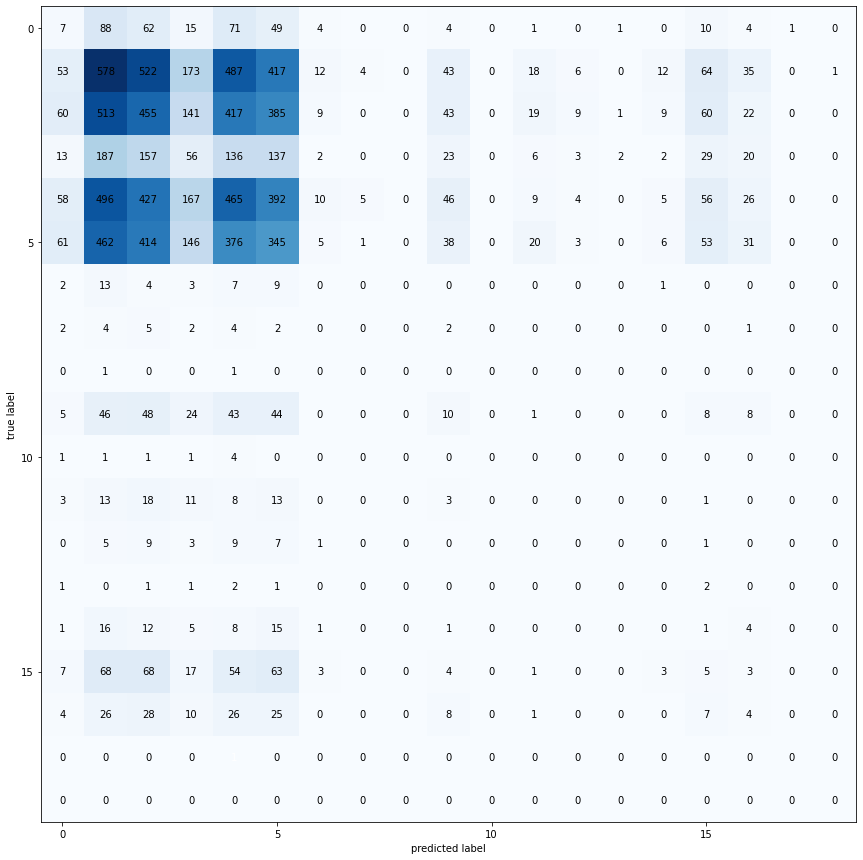

In [ ]:
y_pred_numerical = np.asarray([ np.argmax(pred) for pred in y_pred ])
y_test_numerical =  np.asarray([ np.argmax(test) for test in y_test ])

cm = evaluate.confusion_matrix(y_target=y_test_numerical, 
                      y_predicted=y_pred_numerical, 
                      binary=False)

plt.rcParams["figure.figsize"] = (15,15)
fig, ax = plotting.plot_confusion_matrix(conf_mat=cm)
plt.show()

## CNN+LSTM


In [ ]:
# CNN same as before
model = Sequential(name='allclasses_conv_relu_pool_lstm')
inputShape = (x_train.shape[1], x_train.shape[2])

model.add(Conv1D(filters=64, kernel_size=1, strides=1, input_shape=inputShape, name='conv_1'))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv1D(filters=64, kernel_size=1, strides=1, name='conv_2'))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Conv1D(filters=128, kernel_size=1, strides=1, name='conv_3'))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv1D(filters=128, kernel_size=1, strides=1, name='conv_4'))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# add LSTM
model.add(LSTM(200))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.05))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(nclasses, activation='softmax', name='final_dense'))

# model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics= ['accuracy'])

In [ ]:
plot_model(model, to_file='cnn+lstm_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# define the checkpoint
filepath = path + "allclasses_conv_relu_pool_lstm_bestscores_{}.hdf5".format(EPOCHS)
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
EPOCHS = 200
# H = model.fit(x_train, y_train, validation_split=0.2, epochs=EPOCHS, verbose=1, callbacks=callbacks_list)

tc = TimingCallback()
callbacks = [MonitorCallback(), tc]

H = model.fit(x_train, y_train, validation_split=0.2, epochs=EPOCHS, verbose=1, callbacks=callbacks)

print('TOTAL TIME: ', sum(tc.logs))

# Save model
model.save(path +'allclasses_conv_relu_pool_lstm_endoftraining_{}.h5'.format(EPOCHS))

Epoch 1/200
625/625 [==============================] - 16s 18ms/step - loss: 0.2691 - accuracy: 0.5862 - val_loss: 0.2236 - val_accuracy: 0.2170
Saved model with train loss 0.1236 and val loss 0.2236 at epoch 1
Epoch 2/200
625/625 [==============================] - 10s 17ms/step - loss: 0.0450 - accuracy: 0.8579 - val_loss: 0.1581 - val_accuracy: 0.4408
Saved model with train loss 0.0421 and val loss 0.1581 at epoch 2
Epoch 3/200
625/625 [==============================] - 11s 17ms/step - loss: 0.0337 - accuracy: 0.8990 - val_loss: 0.1643 - val_accuracy: 0.3683
Epoch 4/200
625/625 [==============================] - 11s 17ms/step - loss: 0.0317 - accuracy: 0.8991 - val_loss: 0.1556 - val_accuracy: 0.4183
Saved model with train loss 0.0306 and val loss 0.1556 at epoch 4
Epoch 5/200
625/625 [==============================] - 11s 17ms/step - loss: 0.0301 - accuracy: 0.9094 - val_loss: 0.2148 - val_accuracy: 0.3369
Epoch 6/200
625/625 [==============================] - 10s 17ms/step - loss: 

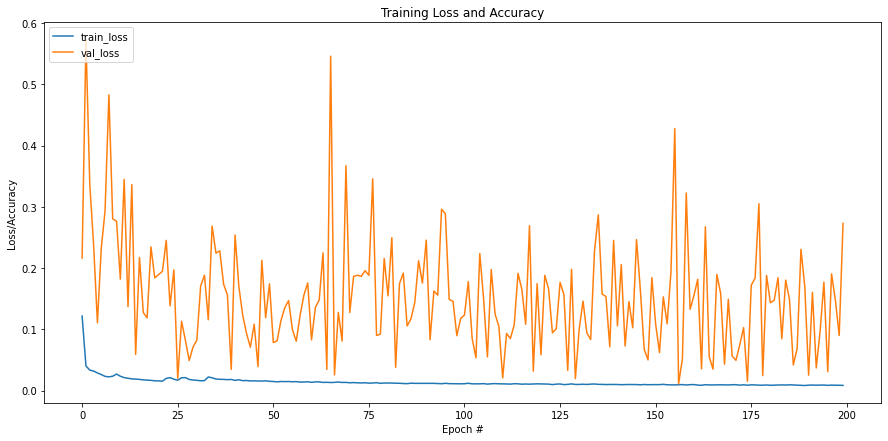

In [ ]:
# plot the training loss and accuracy
plt.figure(figsize=(15,7))

plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

pltname = path + 'allclasses_conv_relu_pool_lstm_{}.png'.format(EPOCHS)
plt.savefig(pltname)

### Evaluation

In [ ]:
EPOCHS = 200
filepath = path + "allclasses_conv_relu_pool_lstm_bestscores_{}.hdf5".format(EPOCHS)

# load the model
model = load_model(filepath)

In [ ]:
x_test.shape, y_test.shape

((10706, 2, 453), (10706, 18))

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

ided_classes = list(np.unique(y_pred)) # classes that have been found
y_pred = to_categorical(y_pred)

missing_classes = []
if y_pred.shape[1] != y_test.shape[1]:
    aux = np.zeros( (y_pred.shape[0], 1) )
    
    missing_classes = [l for l in list(range(0, nclasses)) if l not in ided_classes]
    # print(ided_classes, missing_classes)

#     for m in missing_classes:
#         if m == 18: y_pred = np.hstack((y_pred, aux))
#         else: y_pred = np.insert(y_pred, m, aux, axis=1)

print("Evaluate on test data")
# results = model.evaluate(x_test, y_test)
# print("test loss, test acc:", results)

Evaluate on test data


In [ ]:
y_pred_matrix[0], np.insert(y_pred_matrix, 8, 0, axis=1)[0]

(matrix([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]], dtype=float32),
 matrix([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]], dtype=float32))

In [ ]:
y_pred_matrix = np.asmatrix(y_pred)
for m in missing_classes:
    if m == 18: 
        y_pred_matrix = np.append(y_pred_matrix, 0, axis=1)
    else: 
        y_pred_matrix = np.insert(y_pred_matrix, m, 0, axis=1)

print(y_pred_matrix.shape, y_test.shape)

ValueError: ignored

In [ ]:
y_pred_numerical = np.asarray([ np.argmax(pred) for pred in y_pred ])
y_test_numerical =  np.asarray([ np.argmax(test) for test in y_test ])

cm = evaluate.confusion_matrix(y_target=y_test_numerical, 
                      y_predicted=y_pred_numerical, 
                      binary=False)

plt.rcParams["figure.figsize"] = (15,15)
fig, ax = plotting.plot_confusion_matrix(conf_mat=cm)
plt.show()

## Transfer Learning

https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

https://keras.io/api/applications/


In [ ]:
2*151*3

906

In [ ]:
from keras.applications import DenseNet121, DenseNet169, DenseNet201
from keras import Input

# inputShape = (x_train.shape[1], x_train.shape[2])
'''
seems like we are going to have to reshape the inputs so that every heatmap 
is made up of (1, n, 3) (3 channels)
453/151=3
'''
# inputShape = x_train.shape
inputShape = (2, 151, 3)

# load model, include_top-> allows fixed-sized shape input to be changed
model = DenseNet121(include_top=False, input_shape=inputShape, pooling='max', classes=nclasses) #, input_tensor=Input(shape=inputShape)

In [ ]:
model.summary()

In [ ]:
reshaped_x_train.shape, (x_train.shape[0], 2*151, 3)

((23520, 302, 3), (23520, 302, 3))

In [ ]:
reshaped_x_train=x_train.reshape((x_train.shape[0], 2*151, 3))
model.predict(reshaped_x_train)